# Introduction

In this notebook we look at the when, where, and how much regarding expired LIHTC (Low-Income Housing Tax Credit) projects. 

### Data

|Dataset               | Type           | Description                                     |  Where to get the data |
|----------------------|----------------|-------------------------------------------------|------------------------|
|LIHTCPUB.CSV | CSV | Low-Income Housing Tax Credit original data source | https://www.huduser.gov/portal/datasets/lihtc/property.html |
| LIHTCPUB_Null_Removed.csv                     | CSV               | Some cleaning was done by the team, but it needs documentation/validation        | https://github.com/datakind/affordable-housing-tooling/tree/main/workstream2/datasets|
|tl_2022_us_state.shp  | Shape file | Shape file for US states | https://www.census.gov/cgi-bin/geo/shapefiles/index.php|

### Assumptions And Caveats

- We assume NaN values in column `nonprog` represent non-expired projects, and code these as 0. The remaining values of `nonprog` are coded as 1, which we assume represent expired projects. This is a nontrivial assumption given that this notebook is concerned with investigating expired LIHTC projects, and should likely be checked with domain experts. 
- There are some datatype warnings when importing the LIHTC data using pandas. It may be worth looking into this further. 

### Some Findings

- The majority of expired projects have a year allocation date near 1990.
- Out of 638 projects with a non-null and non-zero allocation amount, only 5 are marked as expired, with an allocation amount ranging from `$445k` to `$1,758k`. Three of these projects have an allocation year of 2007. 

## Python Package Installatation & Imports

In [1]:
!python -V

!pip install geopandas
!pip install pandas
!pip install seaborn

!pip list

Python 3.12.0
Package                       Version
----------------------------- ------------
alabaster                     0.7.13
anyio                         4.0.0
appnope                       0.1.3
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
arrow                         1.3.0
asttokens                     2.4.1
async-lru                     2.0.4
attrs                         23.1.0
Babel                         2.13.0
beautifulsoup4                4.12.2
bleach                        6.1.0
certifi                       2023.7.22
cffi                          1.16.0
charset-normalizer            3.3.1
click                         8.1.7
click-plugins                 1.1.1
cligj                         0.7.2
comm                          0.1.4
contourpy                     1.1.1
cycler                        0.12.1
debugpy                       1.8.0
decorator                     5.1.1
defusedxml                    0.7.1
docutils                     

In [2]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from shapely.geometry import Point, Polygon

## Settings and Data Paths

In [3]:
DATA_DIRECTORY = './datasets'

LIHTCPUB_DATA_PATH = os.path.join(DATA_DIRECTORY, 'LIHTCPUB.CSV')
LIHTCPUB_NULLS_REMOVED_DATA_PATH = os.path.join(DATA_DIRECTORY, 'LIHTCPUB_Null_Removed.csv')
US_STATE_SHAPE_DATA_PATH = os.path.join(DATA_DIRECTORY, 'tl_2022_us_state', 'tl_2022_us_state.shp')

In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Data Prep

In [5]:
df_original = pd.read_csv(LIHTCPUB_DATA_PATH)
# Subset to Florida-based projects
df_original_fl = df_original[df_original['proj_st'] == 'FL'].copy()
# Type casts
df_original_fl['yr_alloc'] = df_original_fl['yr_alloc'].astype('int')

/var/folders/x6/sjylc1gd7kx7zy6h7zzg45440000gn/T/ipykernel_21971/1447053413.py:1: DtypeWarning: Columns (72) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv(LIHTCPUB_DATA_PATH)


In [6]:
# This data source may need additional validation and/or documentation
df_nulls_removed = pd.read_csv(LIHTCPUB_NULLS_REMOVED_DATA_PATH)
# Subset to Florida-based projects
df_nulls_removed_fl = df_nulls_removed[df_nulls_removed['proj_st'] == 'FL'].copy()
# Type casts
df_nulls_removed_fl['yr_alloc'] = df_nulls_removed_fl['yr_alloc'].astype('int')

In [7]:
shape_data = gpd.read_file(US_STATE_SHAPE_DATA_PATH)
shape_data_fl = shape_data[shape_data['NAME'] == 'Florida']

## Analysis

Note: We started our analyses using the original source data set (`df_original_fl`) as well as a modified data set (`df_nulls_removed_fl`) which a team member provided after some data cleaning (e.g. removing some null values), however the latter may need some additional documentation/validation. With that said, the distribution of the data in each case looks similar for relevant columns, hence only the original data source was used for the later analyses. Which data source is used is indicated in the heading of the analysis in parantheses. 

### Quick Look at the data

In [8]:
print(f"Number of Florida projects in original data set: {len(df_original_fl)}")
print(f"Number of Florida projects in revised data set (after some nulls removed): {len(df_nulls_removed_fl)}")

Number of Florida projects in original data set: 1527
Number of Florida projects in revised data set (after some nulls removed): 1218


In [9]:
df_original_fl.head()

,hud_id,project,proj_add,proj_cty,proj_st,proj_zip,state_id,latitude,longitude,place1990,place2000,place2010,fips1990,fips2000,fips2010,st2010,cnty2010,scattered_site_cd,resyndication_cd,allocamt,n_units,li_units,n_0br,n_1br,n_2br,n_3br,n_4br,inc_ceil,low_ceil,ceilunit,yr_pis,yr_alloc,non_prof,basis,bond,mff_ra,fmha_514,fmha_515,fmha_538,home,home_amt,tcap,tcap_amt,cdbg,cdbg_amt,htf,htf_amt,fha,hopevi,hpvi_amt,tcep,tcep_amt,rad,qozf,qozf_amt,rentassist,trgt_pop,trgt_fam,trgt_eld,trgt_dis,trgt_hml,trgt_other,trgt_spc,type,credit,n_unitsr,li_unitr,metro,dda,qct,nonprog,nlm_reason,nlm_spc,datanote,record_stat
8547,FLA00000005,ABSHIRE PROPERTY,1867 MOVA ST,SARASOTA,FL,34231,30,27.221191,-82.494667,793.0,28050.0,73725.0,12115002001,12115002005,12115002005,12,115,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8888,1988,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,X
8548,FLA00000010,AESOP PROPERTY,1405 ELBERTA DR,TALLAHASSEE,FL,32304,31,30.427732,-84.305244,2070.0,70600.0,70600.0,12073002001,12073002001,12073002006,12,73,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8888,1988,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,1.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,X
8549,FLA00000015,ALACHUA VILLAS,14000 NW 154TH AVE,ALACHUA,FL,32615,32,29.796204,-82.494324,NaN,375.0,375.0,12001001801,12001001801,12001001801,12,1,2.0,NaN,NaN,35.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8888,1988,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,35.0,35.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,X
8550,FLA00000020,ARCHER VILLAGE,506 E HIGH ST,ARCHER,FL,32618,41,29.511499,-82.531303,NaN,1775.0,1775.0,12001002201,12001002209,12001002209,12,1,2.0,NaN,NaN,23.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8888,1989,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,23.0,23.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,X
8551,FLA00000024,NORTHBRIDGE APT HOMES ON MILLENIA LAKE I,4902 MILLENIA BLVD,ORLANDO,FL,32839,1134,28.480059,-81.442039,NaN,50638.0,53000.0,12095014500,12095016903,12095016903,12,95,2.0,NaN,NaN,396.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8888,8888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,396.0,396.0,1.0,NaN,NaN,NaN,NaN,NaN,PROPERTY IDENTIFIED IN 2014 LIHTC TENANT DATA ...,U


In [10]:
df_nulls_removed_fl.head()

,hud_id,project,proj_add,proj_cty,proj_st,proj_zip,state_id,latitude,longitude,place1990,place2000,place2010,fips1990,fips2000,fips2010,st2010,cnty2010,scattered_site_cd,resyndication_cd,allocamt,n_units,li_units,n_0br,n_1br,n_2br,n_3br,n_4br,inc_ceil,low_ceil,ceilunit,yr_pis,yr_alloc,non_prof,basis,bond,mff_ra,fmha_514,fmha_515,fmha_538,home,home_amt,tcap,tcap_amt,cdbg,cdbg_amt,htf,htf_amt,fha,hopevi,hpvi_amt,tcep,tcep_amt,rad,qozf,qozf_amt,rentassist,trgt_pop,trgt_fam,trgt_eld,trgt_dis,trgt_hml,trgt_other,trgt_spc,type,credit,n_unitsr,li_unitr,metro,dda,qct,nonprog,nlm_reason,nlm_spc,datanote,record_stat
7164,FLA19900015,CLAY SPRINGS,101 JOEY DR,GREEN COVE SPRINGS,FL,32043,171,29.983334,-81.688232,770.0,27400.0,27400.0,12019031400,12019031400,12019031400,12,19,2.0,NaN,NaN,51.0,51.0,0.0,12.0,33.0,6.0,0.0,NaN,NaN,NaN,1990,1990,2.0,2.0,2.0,NaN,2.0,1.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,51,51,1.0,NaN,2.0,NaN,NaN,NaN,NaN,X
7165,FLA19900045,JEFLIS APTS,2204 E 132ND AVE,TAMPA,FL,33612,401,28.067533,-82.434052,2127.0,71000.0,73163.0,12057010806,12057010806,12057010815,12,57,2.0,NaN,NaN,8.0,8.0,0.0,0.0,0.0,8.0,0.0,NaN,NaN,NaN,1990,1990,2.0,2.0,2.0,NaN,2.0,2.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,2.0,2.0,2.0,2.0,NaN,1.0,2.0,8,8,1.0,NaN,2.0,NaN,NaN,NaN,NaN,X
7166,FLA19910021,COLLEGE PARK,6435 COLLEGE PARK CIR,NAPLES,FL,34113,181,26.106750,-81.700928,1456.0,40037.0,40037.0,12021010800,12021010802,12021010802,12,21,2.0,NaN,NaN,210.0,210.0,0.0,0.0,210.0,0.0,0.0,NaN,NaN,NaN,1991,2000,2.0,2.0,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,210,210,1.0,NaN,2.0,NaN,NaN,NaN,PREVIOUSLY LISTED AS FLA1999055. AKA COLLEGE P...,X
7167,FLA19910025,GARDENIA SQUARE,501 S PARRAMORE ST,MADISON,FL,NaN,285,NaN,NaN,NaN,42425.0,NaN,12079990300,12079990302,12XXXXXXXXX,12,.,2.0,NaN,NaN,12.0,12.0,0.0,0.0,12.0,0.0,0.0,NaN,NaN,NaN,1991,1991,2.0,2.0,2.0,NaN,2.0,1.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,2.0,2.0,2.0,2.0,NaN,1.0,2.0,12,12,3.0,NaN,2.0,NaN,NaN,NaN,NaN,X
7168,FLA19910030,HASSINGER PROPERTIES PHASE C,1913 E 137TH AVE,TAMPA,FL,33613,335,28.071096,-82.437904,2127.0,73163.0,73163.0,12057010807,12057010807,12057010818,12,57,2.0,NaN,NaN,2.0,2.0,0.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,1991,1991,2.0,2.0,2.0,NaN,2.0,2.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2,2,1.0,NaN,2.0,NaN,NaN,NaN,NaN,X


In [11]:
df_original_fl.columns

Index(['hud_id', 'project', 'proj_add', 'proj_cty', 'proj_st', 'proj_zip',
       'state_id', 'latitude', 'longitude', 'place1990', 'place2000',
       'place2010', 'fips1990', 'fips2000', 'fips2010', 'st2010', 'cnty2010',
       'scattered_site_cd', 'resyndication_cd', 'allocamt', 'n_units',
       'li_units', 'n_0br', 'n_1br', 'n_2br', 'n_3br', 'n_4br', 'inc_ceil',
       'low_ceil', 'ceilunit', 'yr_pis', 'yr_alloc', 'non_prof', 'basis',
       'bond', 'mff_ra', 'fmha_514', 'fmha_515', 'fmha_538', 'home',
       'home_amt', 'tcap', 'tcap_amt', 'cdbg', 'cdbg_amt', 'htf', 'htf_amt',
       'fha', 'hopevi', 'hpvi_amt', 'tcep', 'tcep_amt', 'rad', 'qozf',
       'qozf_amt', 'rentassist', 'trgt_pop', 'trgt_fam', 'trgt_eld',
       'trgt_dis', 'trgt_hml', 'trgt_other', 'trgt_spc', 'type', 'credit',
       'n_unitsr', 'li_unitr', 'metro', 'dda', 'qct', 'nonprog', 'nlm_reason',
       'nlm_spc', 'datanote', 'record_stat'],
      dtype='object')

#### Shape Data Info

In [12]:
shape_data_fl.iloc[0]

REGION                                                      3
DIVISION                                                    5
STATEFP                                                    12
STATENS                                              00294478
GEOID                                                      12
STUSPS                                                     FL
NAME                                                  Florida
LSAD                                                       00
MTFCC                                                   G4000
FUNCSTAT                                                    A
ALAND                                            138962819934
AWATER                                            45971472526
INTPTLAT                                          +28.3989775
INTPTLON                                         -082.5143005
geometry    MULTIPOLYGON (((-83.108738 24.629489, -83.1071...
Name: 1, dtype: object

In [13]:
shape_data_fl.crs # indicates EPSG:4269 is being used, for plotting on maps

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

### Analysis of column `nonprog`

#### Column description

From the LIHTC data dictionary, we have the following description of the `nonprog` column:

- "No longer monitored for LIHTC program compliance due to expired use or other reason <sub>2012</sub> (Status of no longer being monitored for the LIHTC Program is indicated for projects as specified by the allocating agency. This does not indicate whether or not a project remains affordable to low income populations.)"
- Footnote <em>2012</em>: "Information first requested with the 2012 properties: TCAP; TCAP_AMT; TCEP; TCEP_AMT"
- Value Labels: "1=Yes"

#### Column Analysis

Below we find the minimum and maximum value in the column is 1, hence all non-null values are 1. On the other hand, there is a large percentage of records that are null (aka NaN). Since the documentation states that 1 corresponds to "Yes", we assume the the null values correspond to "No", and recode these to 0. Hence, we assume 1 represents expired projects, and 0 non-expired projects, which is an assumption that should be checked. 

#### Counts using original data

In [14]:
num_nonprog_nan = np.isnan(df_original_fl['nonprog']).sum()
print(f"Number of NaN (e.g. null/missing) values for column nonprog: {num_nonprog_nan}")

num_nonprog_values = len(df_original_fl[~np.isnan(df_original_fl['nonprog'])])
print(f"Number of (non-null/non-missing) values for column nonprog: {num_nonprog_values}")

nonprog_min = df_original_fl[~np.isnan(df_original_fl['nonprog'])]['nonprog'].min()
nonprog_max = df_original_fl[~np.isnan(df_original_fl['nonprog'])]['nonprog'].max()
print(f"nonprog min value for data with nulls removed: {nonprog_min}")
print(f"nonprog max value for data with nulls removed: {nonprog_min}")

Number of NaN (e.g. null/missing) values for column nonprog: 1325
Number of (non-null/non-missing) values for column nonprog: 202
nonprog min value for data with nulls removed: 1.0
nonprog max value for data with nulls removed: 1.0


#### Counts using data with nulls removed

In [15]:
num_nonprog_nan = np.isnan(df_nulls_removed_fl['nonprog']).sum()
print(f"Number of NaN (e.g. null/missing) values for column nonprog: {num_nonprog_nan}")

num_nonprog_values = len(df_nulls_removed_fl[~np.isnan(df_nulls_removed_fl['nonprog'])])
print(f"Number of (non-null/non-missing) values for column nonprog: {num_nonprog_values}")

nonprog_min = df_nulls_removed_fl[~np.isnan(df_nulls_removed_fl['nonprog'])]['nonprog'].min()
nonprog_max = df_nulls_removed_fl[~np.isnan(df_nulls_removed_fl['nonprog'])]['nonprog'].max()
print(f"nonprog min value for data with nulls removed: {nonprog_min}")
print(f"nonprog max value for data with nulls removed: {nonprog_min}")

Number of NaN (e.g. null/missing) values for column nonprog: 1175
Number of (non-null/non-missing) values for column nonprog: 43
nonprog min value for data with nulls removed: 1.0
nonprog max value for data with nulls removed: 1.0


#### Recoding of `nonprog`

We can see above that the `nonprog` column consists of either NaN (e.g. null/missing) values or else is equal to 1. Hence, moving forward, we will <b>make the assumption</b> that NaN corresponds to non-expired which we will code as 0, while 1 corresponds to expired. 

In [16]:
df_original_fl['expired'] = df_original_fl['nonprog'].replace({np.NaN: 0, 1: 1})
print("Expired project counts for original dataset")
df_original_fl['expired'].value_counts()

Expired project counts for original dataset


expired
0.0    1325
1.0     202
Name: count, dtype: int64

In [17]:
df_nulls_removed_fl['expired'] = df_nulls_removed_fl['nonprog'].replace({np.NaN: 0, 1: 1})
print("Expired project counts for dataset with nulls removed:")
df_nulls_removed_fl['expired'].value_counts()

Expired project counts for dataset with nulls removed:


expired
0.0    1175
1.0      43
Name: count, dtype: int64

### Analysis - The When, Where, and How Much corresponding to expired projects

#### Analysis - When? (Using original dataset)

Columns of interest:

- YR_ALLOC - "Allocation year"

In [18]:
invalid_date_values = [9999, 8888]
invalid_date_filter = ~df_original_fl['yr_alloc'].isin(invalid_date_values)
df_original_fl_yr_alloc = df_original_fl['yr_alloc'][invalid_date_filter].value_counts().sort_index()

Text(0, 0.5, 'Number of Projects')

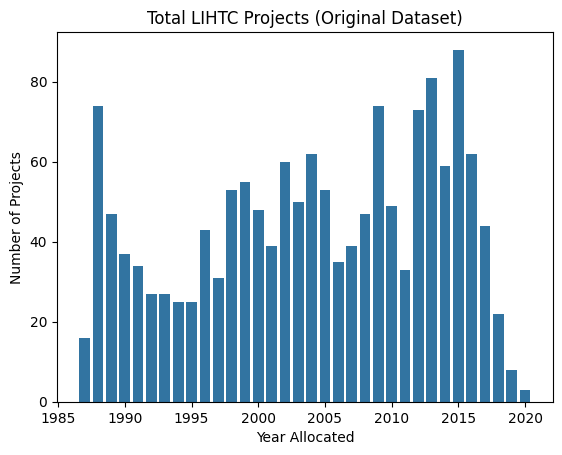

In [19]:
fig = sns.barplot(df_original_fl_yr_alloc, native_scale=True)
fig.set_title('Total LIHTC Projects (Original Dataset)')
fig.set_xlabel("Year Allocated")
fig.set_ylabel("Number of Projects")

In [20]:
invalid_date_values = [9999, 8888]
invalid_date_filter = ~df_original_fl['yr_alloc'].isin(invalid_date_values)
expired_filter = df_original_fl['expired'] == 1
df_original_fl_yr_alloc_expired = df_original_fl['yr_alloc'][invalid_date_filter & expired_filter].value_counts().sort_index()

Text(0, 0.5, 'Number of Projects')

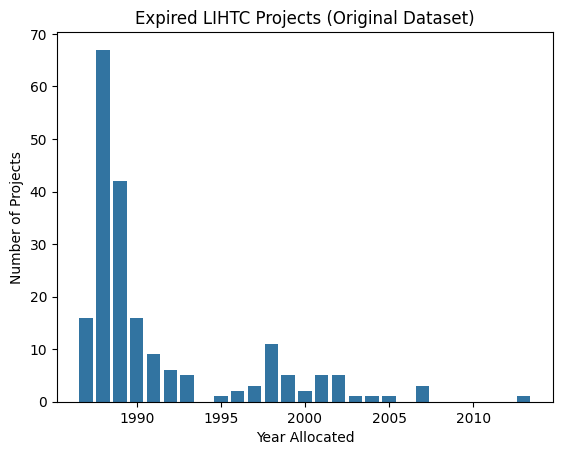

In [21]:
fig = sns.barplot(df_original_fl_yr_alloc_expired, native_scale=True)
fig.set_title('Expired LIHTC Projects (Original Dataset)')
fig.set_xlabel("Year Allocated")
fig.set_ylabel("Number of Projects")

#### Analysis - When? (Using dataset with nulls removed)

Comment: The plot using the cleaned data set looks similar to the plot using the original data source. 

In [22]:
invalid_date_values = [9999, 8888]
invalid_date_filter = ~df_nulls_removed_fl['yr_alloc'].isin(invalid_date_values)
df_nulls_removed_fl_yr_alloc = df_nulls_removed_fl['yr_alloc'][invalid_date_filter].value_counts().sort_index()

Text(0, 0.5, 'Number of Projects')

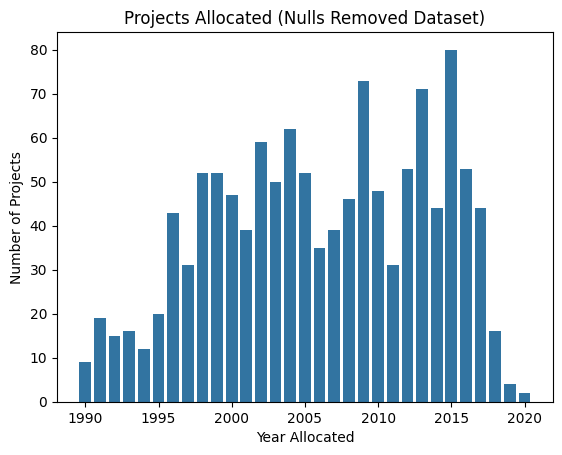

In [23]:
fig = sns.barplot(df_nulls_removed_fl_yr_alloc, native_scale=True)
fig.set_title('Projects Allocated (Nulls Removed Dataset)')
fig.set_xlabel("Year Allocated")
fig.set_ylabel("Number of Projects")

In [24]:
invalid_date_values = [9999, 8888]
invalid_date_filter = ~df_nulls_removed_fl['yr_alloc'].isin(invalid_date_values)
expired_filter = df_nulls_removed_fl['expired'] == 1
df_nulls_removed_fl_yr_alloc_expired = df_nulls_removed_fl['yr_alloc'][invalid_date_filter & expired_filter].value_counts().sort_index()

Text(0, 0.5, 'Number of Projects')

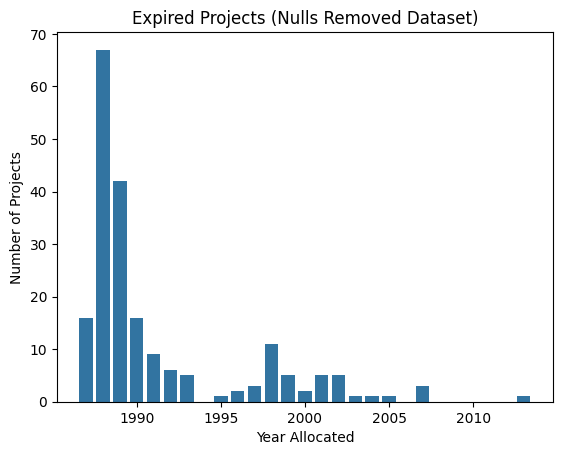

In [25]:
fig = sns.barplot(df_original_fl_yr_alloc_expired, native_scale=True)
fig.set_title('Expired Projects (Nulls Removed Dataset)')
fig.set_xlabel("Year Allocated")
fig.set_ylabel("Number of Projects")

#### Analysis - Where? (Using original dataset)

Potential columns of interest:

- PROJ_CTY
- PROJ_ZIP
- LATITUDE - "Latitude: Degrees Decimal"
- LONGITUD - "Longitude: Negative Degrees Decimal -- GIS Mapping N Convention"
- PLACECE - "Census Place Code (1990)"
- PLACE2010 - "FIPS Place Code (2010)"

In [26]:
# Remove missing values for long/lat
missing_long_lat_filter = np.isnan(df_original_fl['latitude']) | np.isnan(df_original_fl['longitude'])
print(f"There are {missing_long_lat_filter.sum()} missing lat/long values.")

df_original_fl_remove_missing_long_lat = df_original_fl[~missing_long_lat_filter]
print(f"We have {len(df_original_fl_remove_missing_long_lat)} rows after removing missing lat/long values.")

There are 35 missing lat/long values.
We have 1492 rows after removing missing lat/long values.


In [27]:
# Find expired projects
expired_filter_for_long_lat = df_original_fl_remove_missing_long_lat['nonprog'] == 1
df_original_fl_remove_missing_long_lat_expired = df_original_fl_remove_missing_long_lat[expired_filter_for_long_lat].copy()
print(len(df_original_fl_remove_missing_long_lat_expired))

print(f"There are {len(df_original_fl_remove_missing_long_lat_expired)} expired projects with lat/long data available.")

195
There are 195 expired projects with lat/long data available.


In [28]:
geometry_fl = [Point(xy) for xy in zip(df_original_fl_remove_missing_long_lat['longitude'], df_original_fl_remove_missing_long_lat['latitude'])]

In [29]:
geo_df_fl = gpd.GeoDataFrame(data=df_original_fl_remove_missing_long_lat,
                             crs="EPSG:4269",
                             geometry=geometry_fl)
geo_df_fl.head()

,hud_id,project,proj_add,proj_cty,proj_st,proj_zip,state_id,latitude,longitude,place1990,place2000,place2010,fips1990,fips2000,fips2010,st2010,cnty2010,scattered_site_cd,resyndication_cd,allocamt,n_units,li_units,n_0br,n_1br,n_2br,n_3br,n_4br,inc_ceil,low_ceil,ceilunit,yr_pis,yr_alloc,non_prof,basis,bond,mff_ra,fmha_514,fmha_515,fmha_538,home,home_amt,tcap,tcap_amt,cdbg,cdbg_amt,htf,htf_amt,fha,hopevi,hpvi_amt,tcep,tcep_amt,rad,qozf,qozf_amt,rentassist,trgt_pop,trgt_fam,trgt_eld,trgt_dis,trgt_hml,trgt_other,trgt_spc,type,credit,n_unitsr,li_unitr,metro,dda,qct,nonprog,nlm_reason,nlm_spc,datanote,record_stat,expired,geometry
8547,FLA00000005,ABSHIRE PROPERTY,1867 MOVA ST,SARASOTA,FL,34231,30,27.221191,-82.494667,793.0,28050.0,73725.0,12115002001,12115002005,12115002005,12,115,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8888,1988,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,X,1.0,POINT (-82.49467 27.22119)
8548,FLA00000010,AESOP PROPERTY,1405 ELBERTA DR,TALLAHASSEE,FL,32304,31,30.427732,-84.305244,2070.0,70600.0,70600.0,12073002001,12073002001,12073002006,12,73,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8888,1988,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,1.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,X,1.0,POINT (-84.30524 30.42773)
8549,FLA00000015,ALACHUA VILLAS,14000 NW 154TH AVE,ALACHUA,FL,32615,32,29.796204,-82.494324,NaN,375.0,375.0,12001001801,12001001801,12001001801,12,1,2.0,NaN,NaN,35.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8888,1988,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,35.0,35.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,X,1.0,POINT (-82.49432 29.79620)
8550,FLA00000020,ARCHER VILLAGE,506 E HIGH ST,ARCHER,FL,32618,41,29.511499,-82.531303,NaN,1775.0,1775.0,12001002201,12001002209,12001002209,12,1,2.0,NaN,NaN,23.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8888,1989,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,23.0,23.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,X,1.0,POINT (-82.53130 29.51150)
8551,FLA00000024,NORTHBRIDGE APT HOMES ON MILLENIA LAKE I,4902 MILLENIA BLVD,ORLANDO,FL,32839,1134,28.480059,-81.442039,NaN,50638.0,53000.0,12095014500,12095016903,12095016903,12,95,2.0,NaN,NaN,396.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8888,8888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,396.0,396.0,1.0,NaN,NaN,NaN,NaN,NaN,PROPERTY IDENTIFIED IN 2014 LIHTC TENANT DATA ...,U,0.0,POINT (-81.44204 28.48006)


In [30]:
# Remove one outlier location
print(geo_df_fl['latitude'].min(), geo_df_fl['latitude'].max())
print(geo_df_fl['longitude'].min(), geo_df_fl['longitude'].max())
geo_df_fl_remove_outlier = geo_df_fl[geo_df_fl['longitude'] < -76].copy()
print(len(geo_df_fl), len(geo_df_fl_remove_outlier))

24.5507049560547 41.1566009521484
-87.3572540283203 -73.3573989868164
1492 1491


Text(0.5, 1.0, 'Location of All LIHTC Projects')

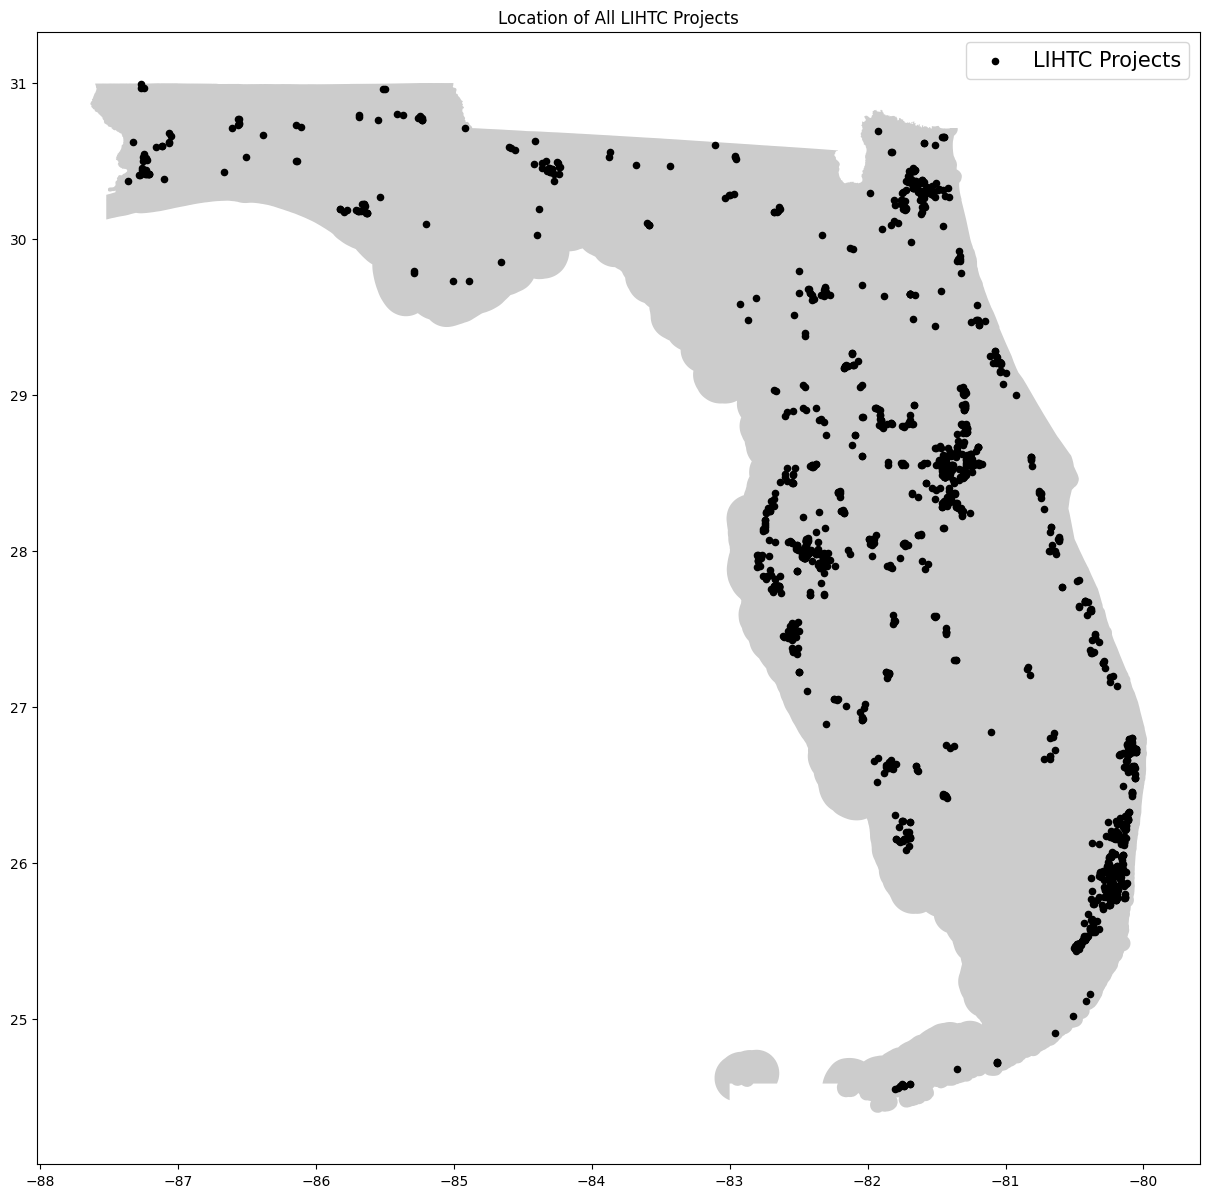

In [31]:
fig, ax = plt.subplots(figsize=(15,15))
shape_data_fl.plot(ax=ax, alpha=0.4, color='grey')
geo_df_fl_remove_outlier.plot(ax=ax, markersize=20, color='black', marker='o', label='LIHTC Projects')
plt.legend(prop={'size':15})
plt.title("Location of All LIHTC Projects")

Text(0.5, 1.0, 'Location of Expired vs. Non-Expired LIHTC Projects')

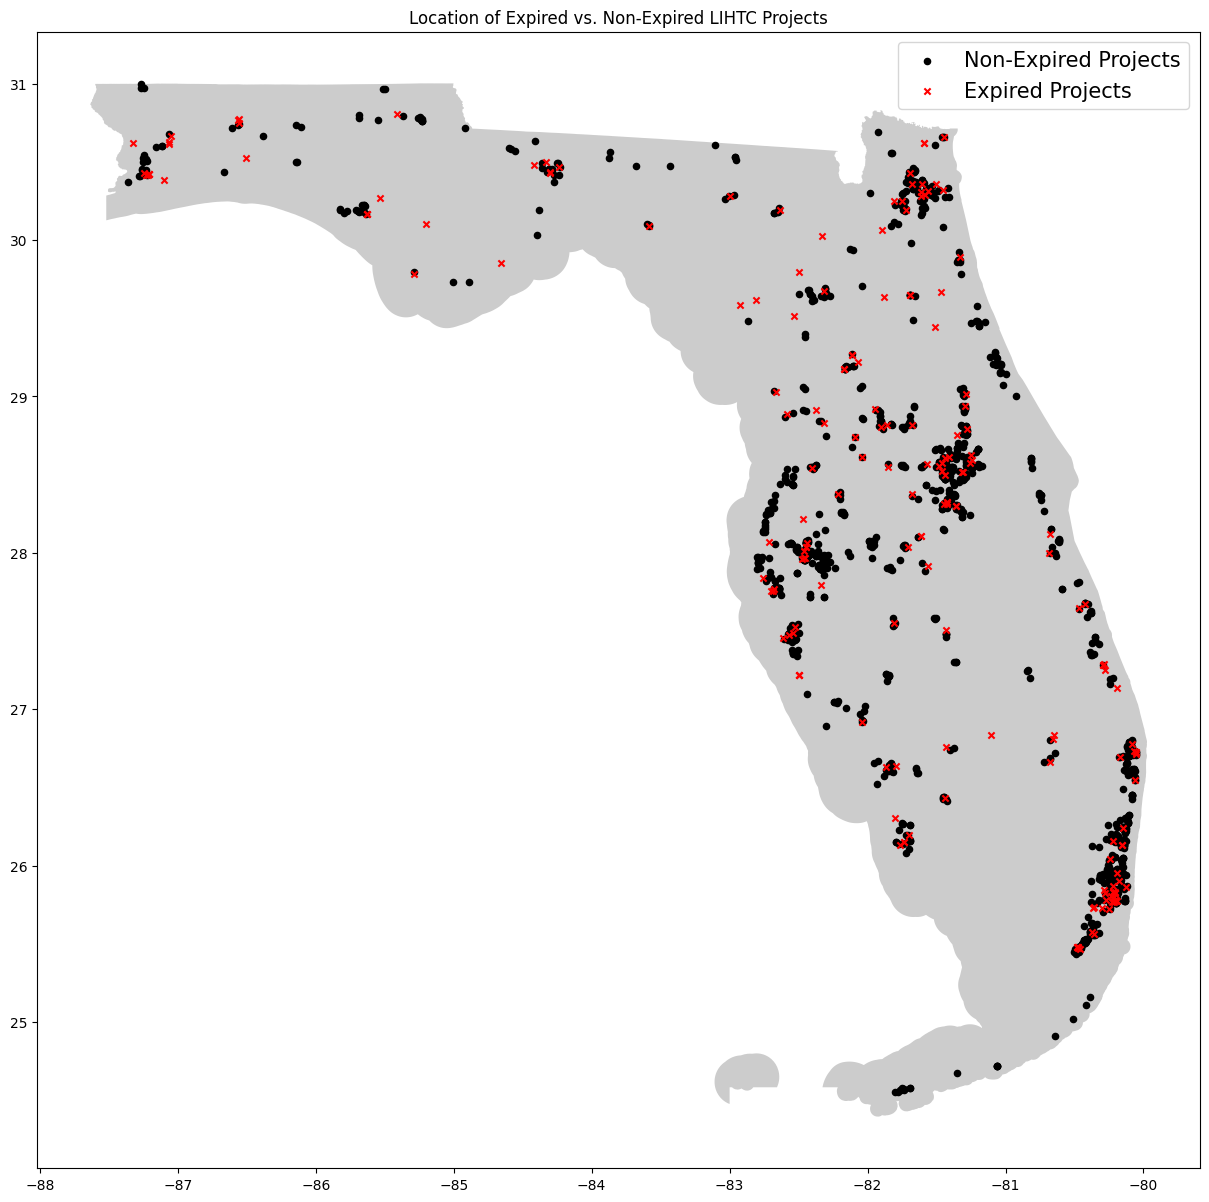

In [32]:
fig, ax = plt.subplots(figsize=(15,15))
shape_data_fl.plot(ax=ax, alpha=0.4, color='grey')
geo_df_fl_remove_outlier[np.isnan(geo_df_fl_remove_outlier['nonprog'])].plot(ax=ax, 
                                                                             markersize=20, 
                                                                             color='black', 
                                                                             marker='o',
                                                                             label='Non-Expired Projects')
geo_df_fl_remove_outlier[~np.isnan(geo_df_fl_remove_outlier['nonprog'])].plot(ax=ax, 
                                                                              markersize=20, 
                                                                              color='red', 
                                                                              marker='x', 
                                                                              label='Expired Projects')
plt.legend(prop={'size': 15})
plt.title("Location of Expired vs. Non-Expired LIHTC Projects")

#### Analysis - How Much? (Using original dataset)

Notes and Observations:

- Out of 1527 projects in the original data set, 885 have missing values for the allocation amount.
- After removing missing values and rows that have a value of $0 for the allocation amount, we are left with 638 rows. 
- Out of 638 projects with a non-null and non-zero allocation amount, only 5 are marked as expired, with an amount ranging from `$445k` to `$1,758k`. 

Columns of interest:

- ALLOCAMT - "Annual dollar amount of tax credits allocated <sub>2006</sub>"

In [33]:
print(f"Out of {len(df_original_fl['allocamt'])} projects, {np.isnan(df_original_fl['allocamt']).sum()} have missing values for the allocation amount.")

Out of 1527 projects, 885 have missing values for the allocation amount.


In [34]:
df_original_fl_remove_missing_allocamt = df_original_fl[~np.isnan(df_original_fl['allocamt'])].copy()

In [35]:
num_zero_allocation = len(df_original_fl_remove_missing_allocamt[df_original_fl_remove_missing_allocamt['allocamt'] == 0])
print(f"There are {num_zero_allocation} projects with an allocated amount of $0")

There are 4 projects with an allocated amount of $0


In [36]:
remove_zero_filter = df_original_fl_remove_missing_allocamt['allocamt'] != 0
df_original_fl_remove_missing_and_zero_allocamt = df_original_fl_remove_missing_allocamt[remove_zero_filter].copy()

In [37]:
df_original_fl_remove_missing_and_zero_allocamt

,hud_id,project,proj_add,proj_cty,proj_st,proj_zip,state_id,latitude,longitude,place1990,place2000,place2010,fips1990,fips2000,fips2010,st2010,cnty2010,scattered_site_cd,resyndication_cd,allocamt,n_units,li_units,n_0br,n_1br,n_2br,n_3br,n_4br,inc_ceil,low_ceil,ceilunit,yr_pis,yr_alloc,non_prof,basis,bond,mff_ra,fmha_514,fmha_515,fmha_538,home,home_amt,tcap,tcap_amt,cdbg,cdbg_amt,htf,htf_amt,fha,hopevi,hpvi_amt,tcep,tcep_amt,rad,qozf,qozf_amt,rentassist,trgt_pop,trgt_fam,trgt_eld,trgt_dis,trgt_hml,trgt_other,trgt_spc,type,credit,n_unitsr,li_unitr,metro,dda,qct,nonprog,nlm_reason,nlm_spc,datanote,record_stat,expired
8752,FLA19920801,REEF CLUB I,1915 REEF CLUB DRIVE,KISSIMMEE,FL,34741,670,28.309414,-81.422966,1075.0,36950.0,36950.0,12097040203,12097041900,12097041900,12,97,NaN,NaN,1758308.0,280.0,280.0,0.0,168.0,280.0,112.0,0.0,2.0,1.0,NaN,1992,2013,2.0,1.0,1.0,NaN,2.0,2.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,2.0,2.0,2.0,2.0,NaN,1.0,1.0,280.0,280.0,1.0,NaN,2.0,1.0,3.0,NaN,PREVIOUSLY LISTED AS FLA1992120. AKA REEF CLUB...,X,1.0
8786,FLA19930802,MIRA LAGOS,358 34TH AVE DRIVE EAST,BRADENTON,FL,34208,500,27.468822,-82.559845,2221.0,7950.0,76740.0,12081000104,12081000104,12081000105,12,81,NaN,NaN,1404547.0,226.0,226.0,0.0,28.0,96.0,76.0,0.0,2.0,1.0,NaN,1993,1993,2.0,2.0,2.0,NaN,2.0,2.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,2.0,2.0,2.0,2.0,NaN,NaN,2.0,226.0,226.0,1.0,NaN,2.0,NaN,NaN,NaN,NaN,X,0.0
8795,FLA19940045,CITRUS GLEN,5351 LIMELIGHT CIRCLE,ORLANDO,FL,32839,166,28.485443,-81.410439,1543.0,50638.0,50638.0,12095016901,12095016904,12095016904,12,95,NaN,NaN,848250.0,176.0,176.0,0.0,0.0,88.0,88.0,0.0,2.0,1.0,NaN,1994,1994,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,1.0,1.0,2.0,2.0,2.0,2.0,NaN,1.0,2.0,176.0,176.0,1.0,NaN,2.0,NaN,NaN,NaN,NaN,X,0.0
8797,FLA19940065,EDISON TERRACES II,655 NW 56 STREET,MIAMI,FL,33127,253,25.826981,-80.207359,1370.0,45000.0,45000.0,12025001904,12086001904,12086001904,12,86,NaN,NaN,329973.0,60.0,50.0,0.0,0.0,50.0,10.0,0.0,2.0,1.0,NaN,1994,2015,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,1.0,1.0,2.0,2.0,2.0,2.0,NaN,1.0,1.0,60.0,50.0,1.0,NaN,2.0,NaN,NaN,NaN,PREVIOUSLY LISTED AS FLA1994810.,X,0.0
8834,FLA19949810,CANOPY PLACE,11050 HARTS ROAD,JACKSONVILLE,FL,32218,273,30.437342,-81.660500,NaN,NaN,35000.0,12XXXXXXXXX,12XXXXXXXXX,12031010304,12,31,NaN,NaN,626807.0,150.0,150.0,0.0,0.0,0.0,142.0,0.0,2.0,1.0,NaN,1994,1993,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,150.0,150.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,U,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10068,FLA20210009,MIDTOWN LOFTS,729 E PARKER STREET,LAKELAND,FL,33801,FL-18-3094,28.051214,-81.949844,NaN,NaN,38250.0,12XXXXXXXXX,12XXXXXXXXX,12105016400,12,105,2.0,2.0,1476331.0,80.0,72.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,8.0,2021,2018,2.0,1.0,NaN,2.0,2.0,2.0,NaN,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,2.0,0.0,2.0,0.0,2.0,2.0,0.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,Family,1.0,2.0,80.0,72.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,N,0.0
10070,FLA20210012,PROMENADE AT GRANDE PARK,9365 GRAND PARK DRIVE,WEEKI WACHEE,FL,34613,FL-19-3153,28.533501,-82.580704,NaN,NaN,49905.0,12XXXXXXXXX,12XXXXXXXXX,12053041600,12,53,2.0,NaN,1500000.0,80.0,80.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,2021,2019,2.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,4.0,1.0,1.0,2.0,2.0,2.0,NaN,NaN,1.0,2.0,80.0,80.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,N,0.0
10071,FLA20210013,QUARRY III,10 BETTY ROSE DRIVE,KEY WEST,FL,33040,FL-19-3146,24.578199,-81.690598,NaN,NaN,6350.0,12X

In [38]:
df_original_fl_remove_missing_and_zero_allocamt[['allocamt', 'expired']]

,allocamt,expired
8752,1758308.0,1.0
8786,1404547.0,0.0
8795,848250.0,0.0
8797,329973.0,0.0
8834,626807.0,0.0
...,...,...
10068,1476331.0,0.0
10070,1500000.0,0.0
10071,925344.0,0.0
10072,2110000.0,0.0


In [39]:
# Number of non-null and non-zero values
len(df_original_fl_remove_missing_and_zero_allocamt[['allocamt', 'expired']])

638

Text(0, 0.5, 'Count of Projects')

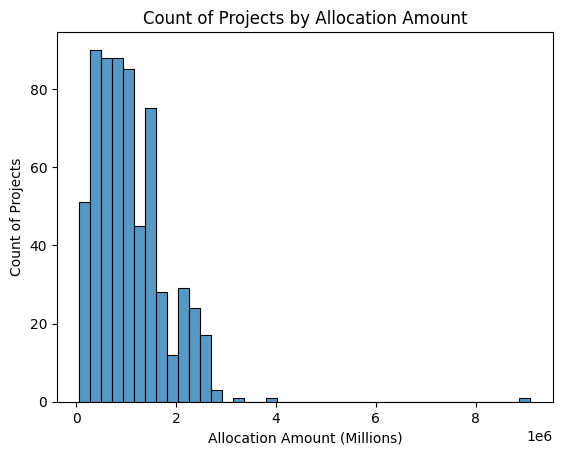

In [40]:
fig = sns.histplot(df_original_fl_remove_missing_and_zero_allocamt['allocamt'])
fig.set_title('Count of Projects by Allocation Amount')
fig.set_xlabel("Allocation Amount (Millions)")
fig.set_ylabel("Count of Projects")

In [41]:
expired_filter = df_original_fl_remove_missing_and_zero_allocamt['nonprog'] == 1
df_original_fl_remove_missing_and_zero_allocamt_expired = df_original_fl_remove_missing_and_zero_allocamt[expired_filter].copy()

In [42]:
len(df_original_fl_remove_missing_and_zero_allocamt_expired)

5

In [43]:
# Format currency
df_original_fl_remove_missing_and_zero_allocamt_expired['allocamt_fmt'] = \
df_original_fl_remove_missing_and_zero_allocamt_expired['allocamt'].apply(lambda x: "${:,.2f}k".format((x / 1000)))

In [44]:
# Allocation Amount for Expired Projects
df_original_fl_remove_missing_and_zero_allocamt_expired.sort_values(by="allocamt")[['project', 'proj_cty', 'allocamt_fmt', 'yr_alloc', 'nonprog']]

,project,proj_cty,allocamt_fmt,yr_alloc,nonprog
9453,WOODSDALE OAKS,LAUDERDALE LAKES,$445.11k,2007,1.0
9416,OCHLOKONEE POINTE,MIDWAY,$561.60k,2004,1.0
9370,VILLAGE AT CORTEZ,BRADENTON,$680.36k,2007,1.0
9516,KIMBERS COVE,JACKSONVILLE,$905.22k,2007,1.0
8752,REEF CLUB I,KISSIMMEE,"$1,758.31k",2013,1.0
